In [1]:
!apt-get  -qq  install  -y  graphviz  &&  pip  install  pydot
!pip  install  -U  matplotlib
!pip  install  git+https://github.com/fastmachinelearning/hls4ml.git@main#egg=hls4ml[profiling]
!pip  install  qkeras==0.9.0

Looking  in  indexes:  https://pypi.org/simple,  https://us-python.pkg.dev/colab-wheels/public/simple/
Requirement  already  satisfied:  pydot  in  /usr/local/lib/python3.7/dist-packages  (1.3.0)
Requirement  already  satisfied:  pyparsing>=2.1.4  in  /usr/local/lib/python3.7/dist-packages  (from  pydot)  (3.0.9)
Looking  in  indexes:  https://pypi.org/simple,  https://us-python.pkg.dev/colab-wheels/public/simple/
Requirement  already  satisfied:  matplotlib  in  /usr/local/lib/python3.7/dist-packages  (3.5.2)
Requirement  already  satisfied:  kiwisolver>=1.0.1  in  /usr/local/lib/python3.7/dist-packages  (from  matplotlib)  (1.4.4)
Requirement  already  satisfied:  cycler>=0.10  in  /usr/local/lib/python3.7/dist-packages  (from  matplotlib)  (0.11.0)
Requirement  already  satisfied:  packaging>=20.0  in  /usr/local/lib/python3.7/dist-packages  (from  matplotlib)  (21.3)
Requirement  already  satisfied:  pyparsing>=2.2.1  in  /usr/local/lib/python3.7/dist-packages  (from  matplotlib)  

# Advanced Configuration

## Load the dataset and model (if you are restarting from this point)

In [21]:
from tensorflow.keras.utils import to_categorical
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline
import plotting

# import os
# os.environ['PATH'] = '/opt/Xilinx/Vivado/2019.2/bin:' + os.environ['PATH']
# for this tutorial we wont be actually running Vivado, so I have commented these lines out
#     but if you want to look into actually running on an FPGA then simply uncomment these lines

X_train_val = np.load("X_train_val.npy")
X_test = np.ascontiguousarray(np.load("X_test.npy"))
y_train_val = np.load("y_train_val.npy")
y_test = np.load("y_test.npy", allow_pickle=True)
classes = np.load("classes.npy", allow_pickle=True)

from tensorflow.keras.models import load_model

model = load_model("model_1/KERAS_check_best_model.h5")
y_keras = model.predict(X_test)

## Make a new hls4ml config & model
This time, we'll create a config with finer granularity. When we print the config dictionary, you'll notice that an entry is created for each named Layer of the model. See for the first layer, for example:
```LayerName:
    fc1:
        Precision:
            weight: ap_fixed<10,4>
            bias:   ap_fixed<10,4>
            result: ap_fixed<10,4>
        ReuseFactor: 1
```
We will also modify the default_precision to be smaller than we know is good just to demonstrate the effect.

In [22]:
import hls4ml

config = hls4ml.utils.config_from_keras_model(
    model, granularity="name", default_precision="ap_fixed<10,4>"
)
print("-----------------------------------")
plotting.print_dict(config)
print("-----------------------------------")

Interpreting Sequential
Topology:
Layer name: fc1_input, layer type: Input
Layer name: fc1, layer type: Dense
  -> Activation (linear), layer name: fc1
Layer name: relu1, layer type: Activation
Layer name: fc2, layer type: Dense
  -> Activation (linear), layer name: fc2
Layer name: relu2, layer type: Activation
Layer name: fc3, layer type: Dense
  -> Activation (linear), layer name: fc3
Layer name: relu3, layer type: Activation
Layer name: output, layer type: Dense
  -> Activation (linear), layer name: output
Layer name: softmax, layer type: Activation
-----------------------------------
Model
  Precision:         ap_fixed<10,4>
  ReuseFactor:       1
  Strategy:          Latency
LayerName
  fc1_input
    Precision
      result:        ap_fixed<10,4>
  fc1
    Precision
      weight:        ap_fixed<10,4>
      bias:          ap_fixed<10,4>
      result:        ap_fixed<10,4>
    ReuseFactor:     1
  fc1_linear
    Precision:       ap_fixed<10,4>
    ReuseFactor:     1
    table_size: 

## Profiling
As you can see, hls4ml will allow is to choose the precision of _everything_ in our Neural Network. This is a powerful way to tune the performance, but it's also complicated. Luckily there are tools in `hls4ml.model.profiling` that will help choose the right precision for a given model.

The first thing we will do is to numerically profile the model. This method plots the distribution of the weights (and biases) as a box and whisker plot. The grey boxes show the values which can be represented with the data types used in the `hls_model`. Generally, you need the box to overlap completely with the whisker 'to the right' (large values) otherwise you'll get saturation & wrap-around issues from exceeding the top of the fixed-point range. It can be okay for the box not to overlap completely 'to the left' (small values), but finding how small you can go is a matter of trial-and-error.

Providing data, in this case just using the first 1000 examples for speed, will show the same distributions captured at the output of each layer.

Interpreting Sequential
Topology:
Layer name: fc1_input, layer type: InputLayer, input shapes: [[None, 16]], output shape: [None, 16]
Layer name: fc1, layer type: Dense, input shapes: [[None, 16]], output shape: [None, 64]
Layer name: relu1, layer type: Activation, input shapes: [[None, 64]], output shape: [None, 64]
Layer name: fc2, layer type: Dense, input shapes: [[None, 64]], output shape: [None, 32]
Layer name: relu2, layer type: Activation, input shapes: [[None, 32]], output shape: [None, 32]
Layer name: fc3, layer type: Dense, input shapes: [[None, 32]], output shape: [None, 32]
Layer name: relu3, layer type: Activation, input shapes: [[None, 32]], output shape: [None, 32]
Layer name: output, layer type: Dense, input shapes: [[None, 32]], output shape: [None, 5]
Layer name: softmax, layer type: Softmax, input shapes: [[None, 5]], output shape: [None, 5]
Creating HLS model
Interpreting Sequential
Topology:
Layer name: fc1_input, layer type: InputLayer, input shapes: [[None, 16]],

(<Figure size 432x288 with 1 Axes>,
 <Figure size 432x288 with 1 Axes>,
 <Figure size 432x288 with 1 Axes>,
 <Figure size 432x288 with 1 Axes>)

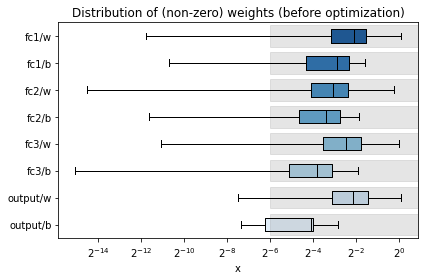

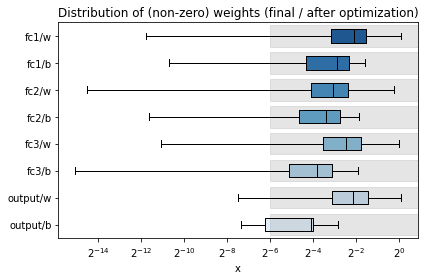

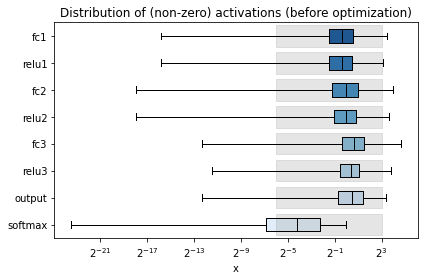

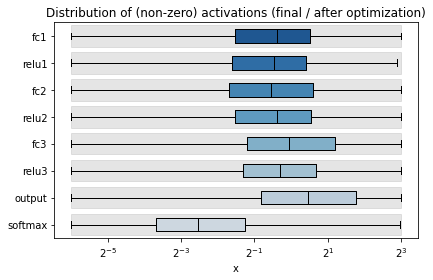

In [24]:
%matplotlib inline
for layer in config["LayerName"].keys():
    config["LayerName"][layer]["Trace"] = True
hls_model = hls4ml.converters.convert_from_keras_model(
    model,
    hls_config=config,
    output_dir="model_1/hls4ml_prj_2",
    part="xcu250-figd2104-2L-e",
)
hls4ml.model.profiling.numerical(model=model, hls_model=hls_model, X=X_test[:1000])

We can see that in this case the default precision of `ap_fixed<16,6>` will fully cover the upper range of the outputs from each layer. This is fully consistent with what we saw earlier from the ROC curve where the fixed-point model was capable of reproducing the floating point result. However, we know that reducing the integer or fractional precision slightly will begin to result in degraded performance.

Writing HLS project
Done
Keras  Accuracy: 0.7516927710843373
hls4ml Accuracy: 0.5088132530120482


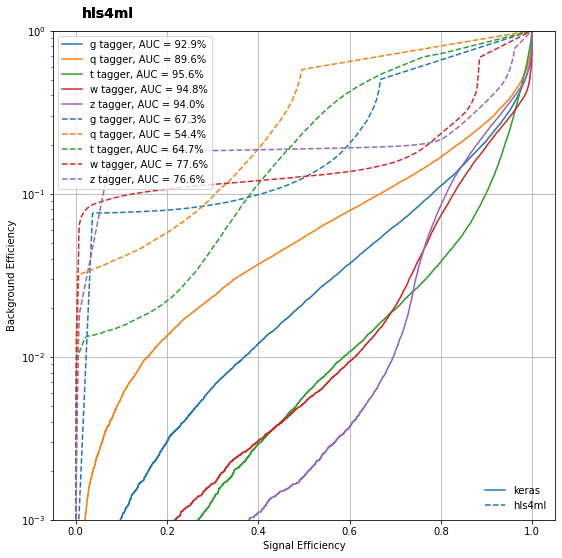

In [25]:
hls_model.compile()
y_hls = hls_model.predict(X_test)

print(
    "Keras  Accuracy: {}".format(
        accuracy_score(np.argmax(y_test, axis=1), np.argmax(y_keras, axis=1))
    )
)
print(
    "hls4ml Accuracy: {}".format(
        accuracy_score(np.argmax(y_test, axis=1), np.argmax(y_hls, axis=1))
    )
)

fig, ax = plt.subplots(figsize=(9, 9))
_ = plotting.makeRoc(y_test, y_keras, classes)
plt.gca().set_prop_cycle(None)  # reset the colors
_ = plotting.makeRoc(y_test, y_hls, classes, linestyle="--")

from matplotlib.lines import Line2D

lines = [Line2D([0], [0], ls="-"), Line2D([0], [0], ls="--")]
from matplotlib.legend import Legend

leg = Legend(ax, lines, labels=["keras", "hls4ml"], loc="lower right", frameon=False)
ax.add_artist(leg)

Not good at all! Let's see if we can figure out how to create a model that will work at these lower precisions.

The first thing we can try is adding some regularizers. This will penalize the model for using large weights, which can help to reduce the number of bits that are necessary.

In [26]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l1
from callbacks import all_callbacks

In [27]:
model = Sequential()
model.add(
    Dense(
        64,
        input_shape=(16,),
        name="fc1",
        kernel_initializer="lecun_uniform",
        kernel_regularizer=l1(0.0001),
    )
)
model.add(Activation(activation="relu", name="relu1"))
model.add(
    Dense(
        32,
        name="fc2",
        kernel_initializer="lecun_uniform",
        kernel_regularizer=l1(0.0001),
    )
)
model.add(Activation(activation="relu", name="relu2"))
model.add(
    Dense(
        32,
        name="fc3",
        kernel_initializer="lecun_uniform",
        kernel_regularizer=l1(0.0001),
    )
)
model.add(Activation(activation="relu", name="relu3"))
model.add(
    Dense(
        5,
        name="output",
        kernel_initializer="lecun_uniform",
        kernel_regularizer=l1(0.0001),
    )
)
model.add(Activation(activation="softmax", name="softmax"))

In [28]:
train = True
if train:
    adam = Adam(lr=0.0001)
    model.compile(
        optimizer=adam, loss=["categorical_crossentropy"], metrics=["accuracy"]
    )
    callbacks = all_callbacks(
        stop_patience=1000,
        lr_factor=0.5,
        lr_patience=10,
        lr_epsilon=0.000001,
        lr_cooldown=2,
        lr_minimum=0.0000001,
        outputDir="model_2",
    )
    model.fit(
        X_train_val,
        y_train_val,
        batch_size=1024,
        epochs=30,
        validation_split=0.25,
        shuffle=True,
        callbacks=callbacks.callbacks,
    )
else:
    from tensorflow.keras.models import load_model

    model = load_model("model_2/KERAS_check_best_model.h5")

Epoch 1/30


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


484/487 [============================>.] - ETA: 0s - loss: 1.3590 - accuracy: 0.4871
***callbacks***
saving losses to model_2/losses.log

Epoch 1: val_loss improved from inf to 1.14819, saving model to model_2/KERAS_check_best_model.h5

Epoch 1: val_loss improved from inf to 1.14819, saving model to model_2/KERAS_check_best_model_weights.h5

Epoch 1: saving model to model_2/KERAS_check_model_last.h5

Epoch 1: saving model to model_2/KERAS_check_model_last_weights.h5

***callbacks end***

487/487 [==============================] - 3s 5ms/step - loss: 1.3580 - accuracy: 0.4876 - val_loss: 1.1482 - val_accuracy: 0.6150 - lr: 1.0000e-04
Epoch 2/30
486/487 [============================>.] - ETA: 0s - loss: 1.0692 - accuracy: 0.6514
***callbacks***
saving losses to model_2/losses.log

Epoch 2: val_loss improved from 1.14819 to 1.01672, saving model to model_2/KERAS_check_best_model.h5

Epoch 2: val_loss improved from 1.14819 to 1.01672, saving model to model_2/KERAS_check_best_model_weights.

Again we will se the default precision to be `ap_fixed<10,4>`.

Interpreting Sequential
Topology:
Layer name: fc1_input, layer type: InputLayer, input shapes: [[None, 16]], output shape: [None, 16]
Layer name: fc1, layer type: Dense, input shapes: [[None, 16]], output shape: [None, 64]
Layer name: relu1, layer type: Activation, input shapes: [[None, 64]], output shape: [None, 64]
Layer name: fc2, layer type: Dense, input shapes: [[None, 64]], output shape: [None, 32]
Layer name: relu2, layer type: Activation, input shapes: [[None, 32]], output shape: [None, 32]
Layer name: fc3, layer type: Dense, input shapes: [[None, 32]], output shape: [None, 32]
Layer name: relu3, layer type: Activation, input shapes: [[None, 32]], output shape: [None, 32]
Layer name: output, layer type: Dense, input shapes: [[None, 32]], output shape: [None, 5]
Layer name: softmax, layer type: Softmax, input shapes: [[None, 5]], output shape: [None, 5]
Creating HLS model
Interpreting Sequential
Topology:
Layer name: fc1_input, layer type: InputLayer, input shapes: [[None, 16]],

(<Figure size 432x288 with 1 Axes>,
 <Figure size 432x288 with 1 Axes>,
 <Figure size 432x288 with 1 Axes>,
 <Figure size 432x288 with 1 Axes>)

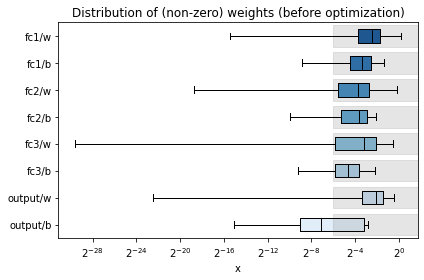

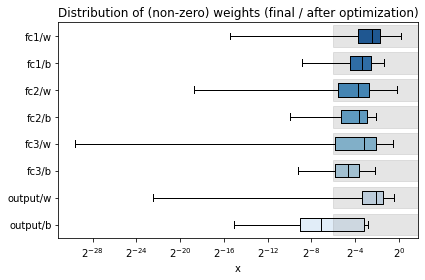

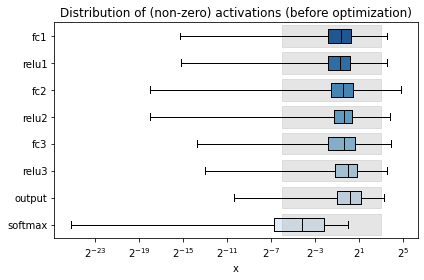

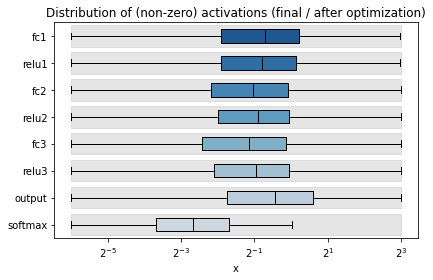

In [29]:
for layer in config["LayerName"].keys():
    config["LayerName"][layer]["Trace"] = True
hls_model = hls4ml.converters.convert_from_keras_model(
    model,
    hls_config=config,
    output_dir="model_2/hls4ml_prj_1",
    part="xcu250-figd2104-2L-e",
)

hls4ml.model.profiling.numerical(model=model, hls_model=hls_model, X=X_test[:1000])

You can see the difference in the weight profile plots between this model and the previous one quite clearly. Whereas before the smallest weight in the first layer was approximately $10^{-14}$, now its almost $10^{-24}$! However, it hasn't markedly improved the upper bound of the layers post-activation, so we will need to try something else.

## Trace
Another thing we can try is to use different precisions in different layers. In this case, it seems that the third layer is the one with the largest output, so perhaps we could increase only that precision and leave the others as is?

In [30]:
config["LayerName"]["fc1"]["Precision"]["weight"] = "ap_fixed<12,6>"
hls_model = hls4ml.converters.convert_from_keras_model(
    model,
    hls_config=config,
    output_dir="model_2/hls4ml_prj_2",
    part="xcu250-figd2104-2L-e",
)

Interpreting Sequential
Topology:
Layer name: fc1_input, layer type: InputLayer, input shapes: [[None, 16]], output shape: [None, 16]
Layer name: fc1, layer type: Dense, input shapes: [[None, 16]], output shape: [None, 64]
Layer name: relu1, layer type: Activation, input shapes: [[None, 64]], output shape: [None, 64]
Layer name: fc2, layer type: Dense, input shapes: [[None, 64]], output shape: [None, 32]
Layer name: relu2, layer type: Activation, input shapes: [[None, 32]], output shape: [None, 32]
Layer name: fc3, layer type: Dense, input shapes: [[None, 32]], output shape: [None, 32]
Layer name: relu3, layer type: Activation, input shapes: [[None, 32]], output shape: [None, 32]
Layer name: output, layer type: Dense, input shapes: [[None, 32]], output shape: [None, 5]
Layer name: softmax, layer type: Softmax, input shapes: [[None, 5]], output shape: [None, 5]
Creating HLS model


Now lets check how this model performs. We are also going to enable a functionality that will extract the intermediate network values from each layer, for botht the hls4ml model and the Keras model.

In [31]:
hls_model.compile()
hls4ml_pred, hls4ml_trace = hls_model.trace(X_test[:1000])
keras_trace = hls4ml.model.profiling.get_ymodel_keras(model, X_test[:1000])
y_hls = hls_model.predict(X_test)

Writing HLS project
Done
Recompiling myproject with tracing
Writing HLS project
Done
Processing fc1 in Keras model...
Processing relu1 in Keras model...
Processing fc2 in Keras model...
Processing relu2 in Keras model...
Processing fc3 in Keras model...
Processing relu3 in Keras model...
Processing output in Keras model...
Processing softmax in Keras model...
Done taking outputs for Keras model.


## Inspect
Now we can print out, make plots, or do any other more detailed analysis on the output of each layer to understand the performance we see. Let's print the output of that third layer, for the first sample, for both the Keras and hls4ml models, and also make a plot of the mean difference per sample

In [32]:
print("Keras layer 'fc3', first sample:")
print(keras_trace["fc3"][0])
print("hls4ml layer 'fc3', first sample:")
print(hls4ml_trace["fc3"][0])
print("layer fc3 diff, first sample:")
print(hls4ml_trace["fc3"][0] - keras_trace["fc3"][0])

Keras layer 'fc3', first sample:
[ 1.3313658  -0.21857885  1.4324812   0.74048215  0.09333943 -0.987783
 -2.0155785   1.0379704   0.1536662   1.9772413  -0.51191765 -0.5156611
  1.2655327   1.3444705   1.3776336   0.25099745 -0.69778293  0.81166637
  0.35837105 -0.02067845 -0.00292974  0.4528223   0.4000891   1.4518489
  0.4011331  -0.12205557 -1.282028    1.3907194   0.85494524  0.12536691
 -1.873413    1.9575386 ]
hls4ml layer 'fc3', first sample:
[ 0.625    -0.421875  0.78125   0.21875  -0.15625  -0.984375 -1.5625
  0.046875  0.078125  0.875    -0.640625 -0.46875   0.484375  0.4375
  0.890625 -0.109375 -0.65625   0.0625   -0.078125 -0.078125 -0.171875
  0.09375  -0.0625    0.46875   0.1875   -0.21875  -0.921875  0.359375
  0.109375 -0.28125  -1.578125  0.71875 ]
layer fc3 diff, first sample:
[-0.70636582 -0.20329615 -0.65123117 -0.52173215 -0.24958943  0.00340801
  0.45307851 -0.99109542 -0.0755412  -1.10224128 -0.12870735  0.04691112
 -0.78115773 -0.9069705  -0.48700857 -0.36037245

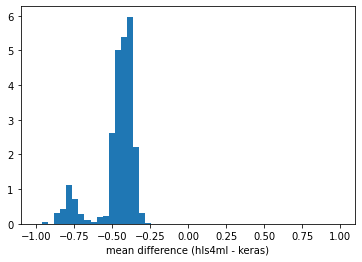

In [33]:
plt.hist(
    np.mean(hls4ml_trace["fc3"] - keras_trace["fc3"], axis=-1),
    bins=np.linspace(-1.0, 1.0, 51),
    density=True,
)
plt.xlabel("mean difference (hls4ml - keras)")

plt.show()

## Compare 
It's not looking great. Let's check the accuracy and ROC curve.

Keras  Accuracy: 0.7516927710843373
hls4ml Accuracy: 0.6118072289156626


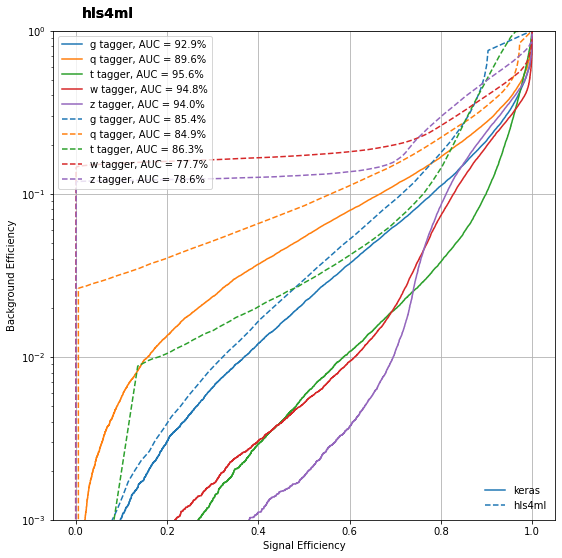

In [34]:
print(
    "Keras  Accuracy: {}".format(
        accuracy_score(np.argmax(y_test, axis=1), np.argmax(y_keras, axis=1))
    )
)
print(
    "hls4ml Accuracy: {}".format(
        accuracy_score(np.argmax(y_test, axis=1), np.argmax(y_hls, axis=1))
    )
)

fig, ax = plt.subplots(figsize=(9, 9))
_ = plotting.makeRoc(y_test, y_keras, classes)
plt.gca().set_prop_cycle(None)  # reset the colors
_ = plotting.makeRoc(y_test, y_hls, classes, linestyle="--")

from matplotlib.lines import Line2D

lines = [Line2D([0], [0], ls="-"), Line2D([0], [0], ls="--")]
from matplotlib.legend import Legend

leg = Legend(ax, lines, labels=["keras", "hls4ml"], loc="lower right", frameon=False)
ax.add_artist(leg)

### Improving
Better, but still not great, especially depending on which class we look at. In principle we could try this for other layers, but eventually we may find we are just back to a larger model. Let's look at some other methods for reducing the size of the network.